<a href="https://colab.research.google.com/github/lourencocavalcante/Neurocomputacao/blob/main/CAP351_Projeto_01_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" align="middle">](https://www.gov.br/inpe/pt-br)

[<center><img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 500 align="middle"></center>](http://www.inpe.br/posgraduacao/cap/)


---


# **CAP-351 Neurocomputação**

**Professor:**

* Dr. Marcos Goncalves Quiles

**Aluno:**
* Lourenço José Cavalcante Neto

# PROPOSTA DE PROJETO 1:

# REDE MLP:: Multi-layer Perceptron (MLP)

1. Selecionar dois datasets (não triviais)

  * Um dataset para classificação
  * Um dataset para regressão
  * Separar em treino/validação/teste

2. Treinar modelos MLP para os dois problemas

3. Considerar:
  * Diferentes topologias (>=5 topologias, variar número de
camadas)
  * Usar o algoritmo original SGD (não usar algoritmos otimizados,
e.g. ADAM)
  * Avaliar o impacto do uso do Momentum
  * Avaliar o impacto do uso da regularização (i.e. L2)

4. Ilustrar graficamente a evolução do treinamento (treino/validação).

5. Confeccionar um relatório (reprodutível) contendo os
experimentos e resultados

**Bibliotecas**

In [164]:
import pandas as pd

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
import datetime
print(tf.__version__)

2.8.2


In [165]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Dataset**

Importando os dados do **disdrômetro RD80 (Joss**)

Dados do disdrômetro RD80. Chamado comumente de Joss. 
Este equipamento mede a distribuição das gotas de chuva que chegam à superfície.


In [244]:
#Carregando o Dataset CSV e criando o Dataframe
df_rd80_joss = pd.read_csv("/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/df_final_rd80_joss.csv")
df_rd80_joss = pd.DataFrame(df_rd80_joss)


#Aqui verificamos o tamanho do Dataset e quantidade de atributos
print('Tamanho do dataset: ',df_rd80_joss.shape[0], ', quantidade de atributos: ', df_rd80_joss.shape[1])

Tamanho do dataset:  315420 , quantidade de atributos:  6


In [ ]:
df_rd80_joss.isna().sum()

In [246]:
df_rd80_joss.dropna(inplace=True)
df_rd80_joss.reset_index(inplace=True, drop=True)

In [ ]:
df_rd80_joss.isna().sum()

In [249]:
df_rd80_joss.head()

,Datetime,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),Liquid watercontent (g/m3),Mean weight diameter(mm),Time integration (s)
0,2020-03-17 13:52:00,0.0,0.0,0.0,0.0,60.0
1,2020-03-17 13:53:00,0.0,0.0,0.0,0.0,60.0
2,2020-03-17 13:54:00,0.0,0.0,0.0,0.0,60.0
3,2020-03-17 13:55:00,0.0,0.0,0.0,0.0,60.0
4,2020-03-17 13:56:00,0.0,0.0,0.0,0.0,60.0


In [250]:
#Vamos assumir que os valores para Rain Intensity (mm/h) que forem menores que 0.1 sejam considerados como 0(zero)
df_rd80_joss['Rain Intensity (mm/h)'][df_rd80_joss['Rain Intensity (mm/h)'] < 0.1] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [251]:
df_rd80_joss.head()

,Datetime,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),Liquid watercontent (g/m3),Mean weight diameter(mm),Time integration (s)
0,2020-03-17 13:52:00,0.0,0.0,0.0,0.0,60.0
1,2020-03-17 13:53:00,0.0,0.0,0.0,0.0,60.0
2,2020-03-17 13:54:00,0.0,0.0,0.0,0.0,60.0
3,2020-03-17 13:55:00,0.0,0.0,0.0,0.0,60.0
4,2020-03-17 13:56:00,0.0,0.0,0.0,0.0,60.0


In [252]:
df_rd80_joss.describe()

,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),Liquid watercontent (g/m3),Mean weight diameter(mm),Time integration (s)
count,315420.000000,315420.000000,315420.000000,315420.000000,315420.0
mean,0.372430,309.362454,0.018214,0.114891,60.0
std,3.418582,4704.699349,0.147274,0.356634,0.0
min,0.000000,0.000000,0.000000,0.000000,60.0
25%,0.000000,0.000000,0.000000,0.000000,60.0
50%,0.000000,0.000000,0.000000,0.000000,60.0
75%,0.000000,0.000000,0.000000,0.000000,60.0
max,128.895370,550486.250000,4.893830,5.361310,60.0


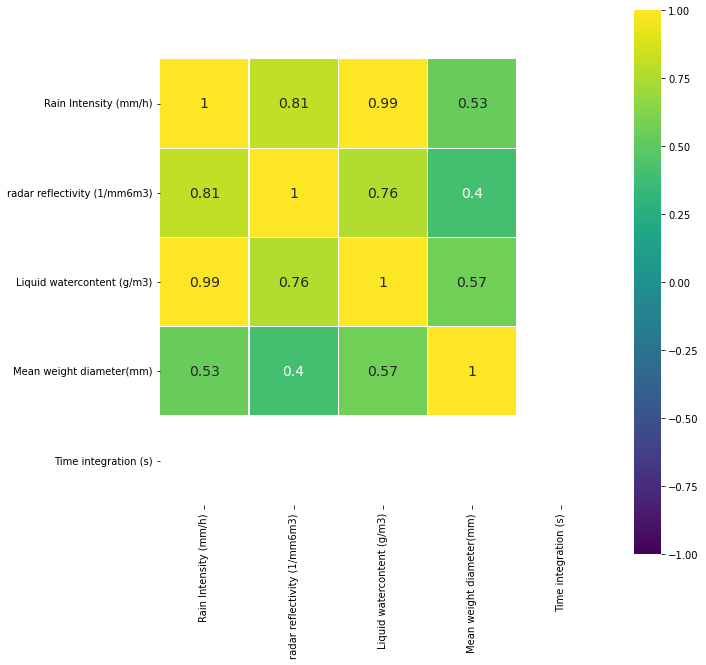

In [253]:
corr = df_rd80_joss.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 14}, square=True);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


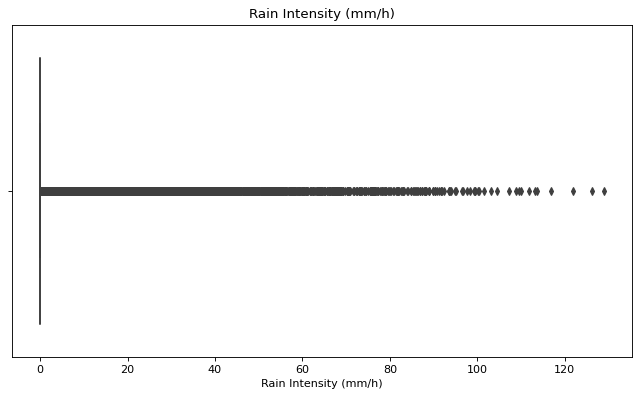

In [254]:
figure(figsize=(10,5.5),dpi=80)
g = sns.boxplot(df_rd80_joss['Rain Intensity (mm/h)'])
g.set_title('Rain Intensity (mm/h)')
plt.show()

[]

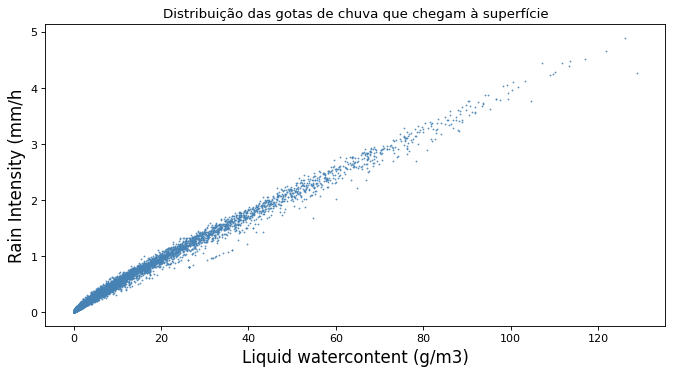

In [258]:
figure(figsize=(10,5),dpi=80)
plt.scatter(df_rd80_joss['Rain Intensity (mm/h)'] ,df_rd80_joss['Liquid watercontent (g/m3)'],s=0.3, color='#4682B4')
plt.xlabel(r'Liquid watercontent (g/m3)',size=15)
plt.ylabel(r'Rain Intensity (mm/h',size=15)
plt.title("Distribuição das gotas de chuva que chegam à superfície")
plt.plot()

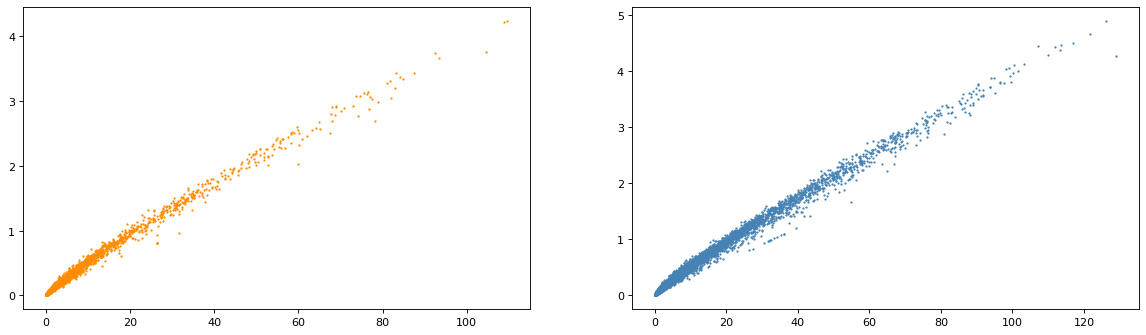

Tamanho do dataset para treinamento:  63084
Tamanho do dataset para validação:  252336


In [213]:
# Divisão do Dataset em treinamento e validação
x_train, x_test, y_train, y_test = train_test_split(df_rd80_joss['Rain Intensity (mm/h)'] ,df_rd80_joss['Liquid watercontent (g/m3)'], test_size=0.8)
figure(figsize=(18,5),dpi=80)
plt.subplot(1,2,1)
plt.title('Dados para Treinamento')
plt.scatter(x_train, y_train, color='#FF8C00',s=1)
plt.subplot(1,2,2)
plt.title('Dados para Teste')
plt.scatter(x_test, y_test, color='#4682B4',s=1)
plt.show()


print('Tamanho do dataset para treinamento: ',len(x_train))
print('Tamanho do dataset para validação: ',len(x_test))

**Criação dos modelos**

Com o objetivo de construir uma rede capaz de encontrar uma lei de regressão para esses *problemas*, serão geradas 5 topologias de rede diferentes. O primeiro será o caso simples e clássico de um perceptron e o segundo aumentará o número de camadas e o número de neurônios.

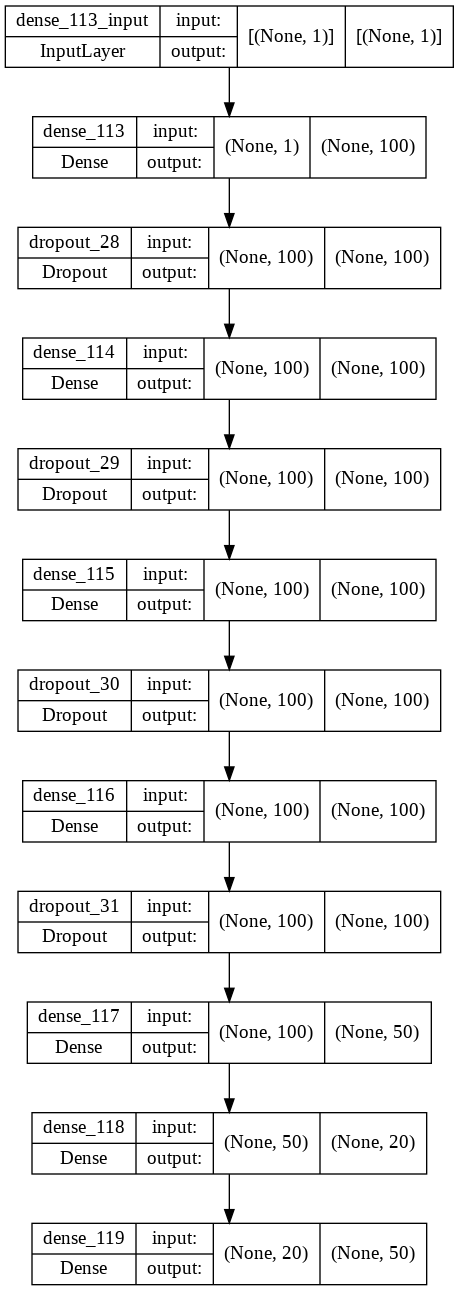

In [259]:
fl2 = 0.0
drop = 0.2

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0)
sgd_momentum_060 = SGD(learning_rate=0.01, decay=1e-6, momentum=0.60, nesterov=True)
adam = tf.keras.optimizers.Adam()

#modelo_a -- Simple Case
modelo_a = keras.Sequential()
modelo_a.add(keras.layers.Dense(units=3, input_shape=[1], activation="tanh"))
modelo_a.add(keras.layers.Dense(units=1, activation="linear"))
#tf.keras.utils.plot_model(modelo_a, show_shapes=True)

#modelo_b
modelo_b = keras.Sequential()
modelo_b.add(keras.layers.Dense(units=5, input_shape=[1], activation="tanh"))
modelo_b.add(keras.layers.Dense(units=5, activation="tanh"))
modelo_b.add(keras.layers.Dense(units=1, activation="linear"))
#tf.keras.utils.plot_model(modelo_b, show_shapes=True)

#modelo_c
modelo_c = keras.Sequential()
modelo_c.add(keras.layers.Dense(units=5, input_shape=[1], activation="tanh"))
modelo_c.add(keras.layers.Dense(units=5, activation="tanh"))
modelo_c.add(keras.layers.Dense(units=1, activation="linear"))
#tf.keras.utils.plot_model(modelo_c, show_shapes=True)

#modelo_final - Suposto melhor modelo
modelo_final = keras.Sequential()
modelo_final.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
modelo_final.add(Dropout(drop))
modelo_final.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
modelo_final.add(Dropout(drop))
modelo_final.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
modelo_final.add(Dropout(drop))
modelo_final.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
modelo_final.add(Dropout(drop))
modelo_final.add(keras.layers.Dense(units=50, kernel_regularizer=l2(fl2), activation="tanh"))
modelo_final.add(keras.layers.Dense(units=20, kernel_regularizer=l2(fl2), activation="sigmoid"))
modelo_final.add(keras.layers.Dense(units=50, activation="linear"))
tf.keras.utils.plot_model(modelo_final, show_shapes=True)

**Compilando os Modelos criados**

In [260]:
modelo_a.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])
modelo_b.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])
modelo_c.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])
modelo_final.compile(loss='mean_squared_error', optimizer=sgd_momentum_060, metrics=["mean_absolute_error"])

lista_modelos = [modelo_a, modelo_b, modelo_c, modelo_final]

**Agora vamos treinar os Modelos**

In [261]:
epocas = 300 #Degine a quantidade de épocas para o treinamento

early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history_modelo_a = modelo_a.fit(x_train, y_train, epochs=epocas, batch_size=10, validation_split=0.2, verbose=True) #callbacks=[early])
history_modelo_b = modelo_b.fit(x_train, y_train, epochs=epocas, batch_size=10, validation_split=0.2, verbose=True) #callbacks=[early])
history_modelo_c = modelo_c.fit(x_train, y_train, epochs=epocas, batch_size=10, validation_split=0.2, verbose=True) #callbacks=[early])
history_modelo_final = modelo_final.fit(x_train, y_train, epochs=epocas, batch_size=10, validation_split=0.2, verbose=True) #callbacks=[early])

lista_history_modelos = [history_modelo_a, history_modelo_b, history_modelo_c, history_modelo_final]

Epoch 1/300
5047/5047 [==============================] - 14s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0255 - val_loss: 0.0048 - val_mean_absolute_error: 0.0166
Epoch 2/300
5047/5047 [==============================] - 14s 3ms/step - loss: 0.0038 - mean_absolute_error: 0.0122 - val_loss: 0.0028 - val_mean_absolute_error: 0.0107
Epoch 3/300
5047/5047 [==============================] - 14s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0087 - val_loss: 0.0017 - val_mean_absolute_error: 0.0082
Epoch 4/300
5047/5047 [==============================] - 14s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0071 - val_loss: 0.0014 - val_mean_absolute_error: 0.0064
Epoch 5/300
5047/5047 [==============================] - 14s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0062 - val_loss: 9.9898e-04 - val_mean_absolute_error: 0.0052
Epoch 6/300
5047/5047 [==============================] - 14s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0059 - val_loss: 8.5691e-04 - val_mean_absolut

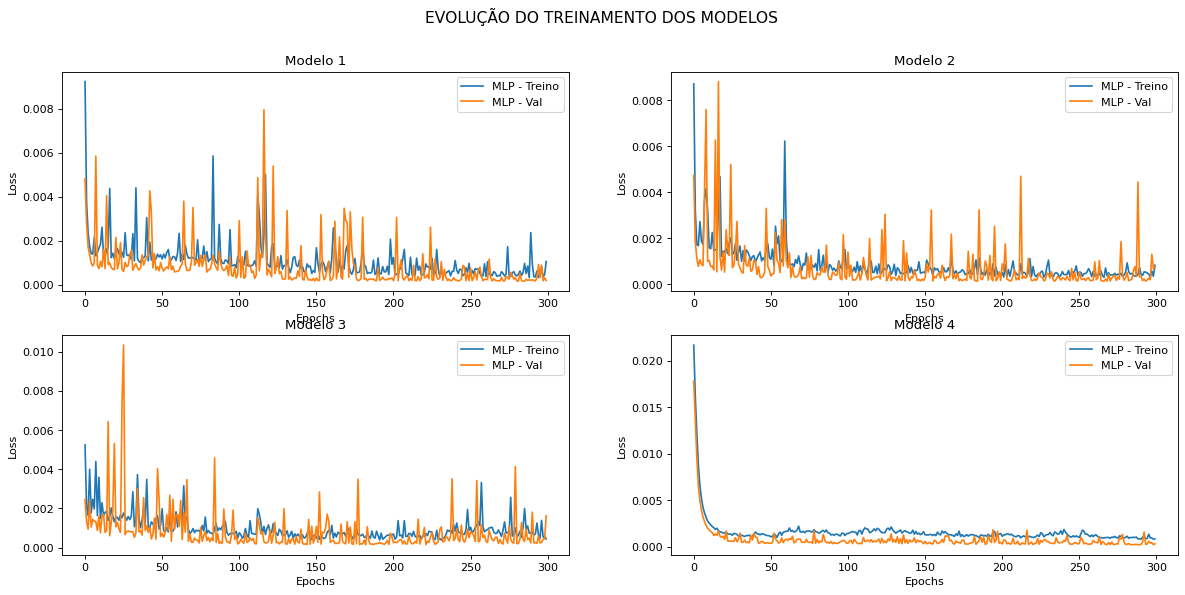

In [262]:
figure(figsize=(18,8),dpi=80)
plt.suptitle('EVOLUÇÃO DO TREINAMENTO DOS MODELOS', size=14)
for i, history_modelo in zip(range(0, len(lista_history_modelos)), lista_history_modelos):
    plt.subplot(2,2,i+1)
    plt.title('Modelo '+ str(i+1))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(history_modelo.history['loss'], label="MLP - Treino")
    plt.plot(history_modelo.history['val_loss'], label="MLP - Val")
    plt.legend()
plt.show()

**Avaliação (teste)**

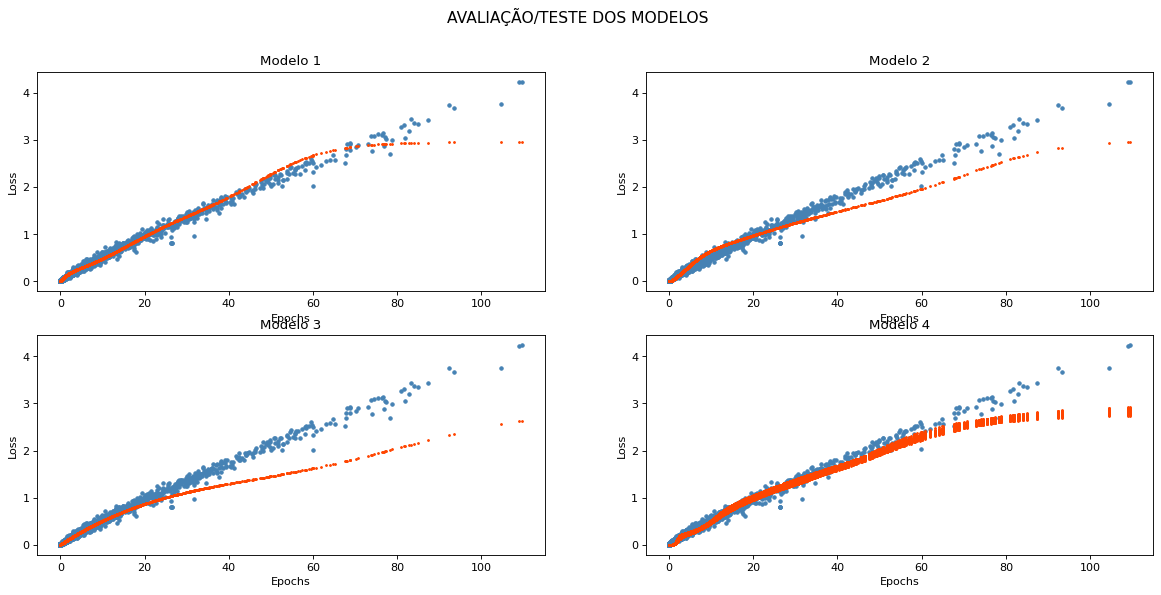

In [263]:
figure(figsize=(18,8),dpi=80)
plt.suptitle('AVALIAÇÃO/TESTE DOS MODELOS', size=14)

for m, res_modelo in zip(range(0, len(lista_modelos)), lista_modelos):

  plt.subplot(2,2,m+1)
  y_rest = res_modelo.predict(x_train)
  plt.plot(x_train, y_train, '.', color='#4682B4')
  plt.plot(x_train, y_rest, '.', markersize=3 ,color='#FF4500')
  plt.title('Modelo '+ str(m+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()

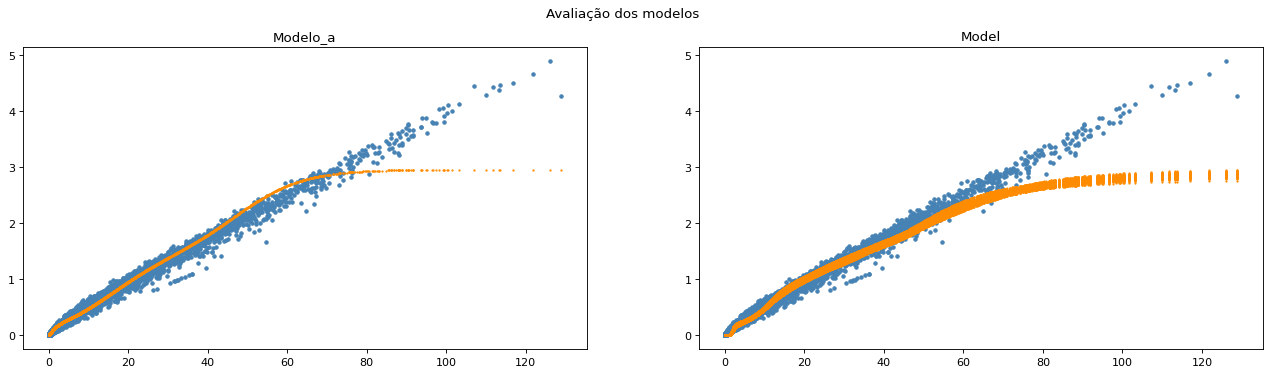

7886/7886 [==============================] - 17s 2ms/step - loss: 5.3005e-04 - mean_absolute_error: 0.0048


In [264]:
figure(figsize=(20,5),dpi=80)
plt.suptitle('Avaliação dos modelos')
plt.subplot(1,2,1)
y_res = modelo_a.predict(x_test)
plt.plot(x_test, y_test, '.', color='#4682B4')
plt.plot(x_test, y_res, '.', markersize=2, color='#FF8C00')
plt.title('Modelo_a')

plt.subplot(1,2,2)
y_res = modelo_final.predict(x_test)
plt.plot(x_test, y_test, '.', color='#4682B4')
plt.plot(x_test, y_res, '.', markersize=2, color='#FF8C00')
plt.title('Model')


plt.show()

test_loss = modelo_a.evaluate(x_test, y_test)
test_loss = modelo_b.evaluate(x_test, y_test)
test_loss = modelo_c.evaluate(x_test, y_test)
test_loss = modelo_final.evaluate(x_test, y_test)

In [265]:
score_modelo_a = modelo_a.evaluate(x_test, y_test, verbose=0)
print("Teste loss:", score_modelo_a[0])
print("Teste metric:", score_modelo_a[1])
print("\n\n")
score_modelo_b = modelo_b.evaluate(x_test, y_test, verbose=0)
print("Teste loss:", score_modelo_b[0])
print("Teste metric:", score_modelo_b[1])
print("\n\n")
score_modelo_c = modelo_c.evaluate(x_test, y_test, verbose=0)
print("Teste loss:", score_modelo_c[0])
print("Teste metric:", score_modelo_c[1])
print("\n\n")
score_model_final = modelo_final.evaluate(x_test, y_test, verbose=0)
print("Teste loss:", score_model_final[0])
print("Teste metric:", score_model_final[1])

Teste loss: 0.00035688866046257317
Teste metric: 0.0032094819471240044



Teste loss: 0.0008907499141059816
Teste metric: 0.00457207253202796



Teste loss: 0.0018526342464610934
Teste metric: 0.004280781839042902



Teste loss: 0.0005300493212416768
Teste metric: 0.004824765492230654
